In [1]:
!pip install tensorflow==2.3.1 tensorflow-addons==0.11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 25 kB/s 
     |████████████████████████████████| 1.1 MB 58.3 MB/s 
     |████████████████████████████████| 2.9 MB 53.0 MB/s 
     |████████████████████████████████| 459 kB 69.7 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      

In [2]:
!git clone https://github.com/IritaSee/super-resolution-colab.git

Cloning into 'super-resolution'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 408 (delta 0), reused 2 (delta 0), pack-reused 405
Receiving objects: 100% (408/408), 48.16 MiB | 37.82 MiB/s, done.
Resolving deltas: 100% (214/214), done.


In [3]:
%cd super-resolution

/content/super-resolution


In [4]:
!ls

article.ipynb  docs		   example-srgan.ipynb	model	   utils.py
data.py        environment.yml	   example-wdsr.ipynb	README.md
demo	       example-edsr.ipynb  LICENSE		train.py


# SRGAN

In [5]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer

%matplotlib inline

In [6]:
# Location of model weights (needed for demo)
weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

## Datasets

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# div2k_train = DIV2K(scale=4, subset='train', downgrade='bicubic')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')

In [9]:
# train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
# valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-srgan.tar.gz](https://martin-krasser.de/sisr/weights-srgan.tar.gz) and extract the archive in the project's root directory. This will create a folder `weights/srgan` containing the weights of the pre-trained models.

In [8]:
!wget https://martin-krasser.de/sisr/weights-srgan.tar.gz

--2022-07-13 19:29:48--  https://martin-krasser.de/sisr/weights-srgan.tar.gz
Resolving martin-krasser.de (martin-krasser.de)... 217.160.0.142, 2001:8d8:100f:f000::209
Connecting to martin-krasser.de (martin-krasser.de)|217.160.0.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99033507 (94M) [application/gzip]
Saving to: ‘weights-srgan.tar.gz’

weights-srgan.tar.g 100%[===================>]  94.45M  28.7MB/s    in 4.0s    

2022-07-13 19:29:52 (23.9 MB/s) - ‘weights-srgan.tar.gz’ saved [99033507/99033507]



In [9]:
!mv ./weights-srgan.tar.gz ./weights/srgan/weights-srgan.tar.gz

In [10]:
!tar -xf ./weights/srgan/weights-srgan.tar.gz

### Generator pre-training

In [13]:
# pre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')
# pre_trainer.train(train_ds,
#                   valid_ds.take(10),
#                   #steps=1000000,
#                   steps = 10000, 
#                   evaluate_every=1000, 
#                   save_best_only=False)

# pre_trainer.model.save_weights(weights_file('pre_generator.h5'))

### Generator fine-tuning (GAN)

In [15]:
gan_generator = generator()
gan_generator.load_weights(weights_file('pre_generator.h5'))

# gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator())
# #gan_trainer.train(train_ds, steps=200000)
# gan_trainer.train(train_ds, steps=1000)

In [ ]:
# gan_trainer.generator.save_weights(weights_file('gan_generator.h5'))
# gan_trainer.discriminator.save_weights(weights_file('gan_discriminator.h5'))

## Demo

In [11]:
pre_generator = generator()
gan_generator = generator()

pre_generator.load_weights(weights_file('pre_generator.h5'))
gan_generator.load_weights(weights_file('gan_generator.h5'))

In [31]:
from model import resolve_single
from utils import load_image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    pre_sr = resolve_single(pre_generator, lr)
    gan_sr = resolve_single(gan_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, pre_sr, gan_sr]
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

In [41]:
from model import resolve_single
from utils import load_image
from PIL import Image
import numpy as np

def convert_and_plot(lr_image_path):
    lr = np.array(Image.open(lr_image_path).convert('RGB'))
    
    pre_sr = resolve_single(pre_generator, lr)
    gan_sr = resolve_single(gan_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, pre_sr, gan_sr]
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

In [43]:
import cv2
img = cv2.imread('/content/drive/MyDrive/super-resolution-master/new_dataset/PET-radiomics-challenges-kaggle/Test/1.3.6.1.4.1.14519.5.2.1.1707.8040.25195525414862185542009647.png')
print(img.shape)
img2 = cv2.imread('demo/0829x4-crop.png')
print(img2.shape)

(128, 128, 3)
(118, 124, 3)


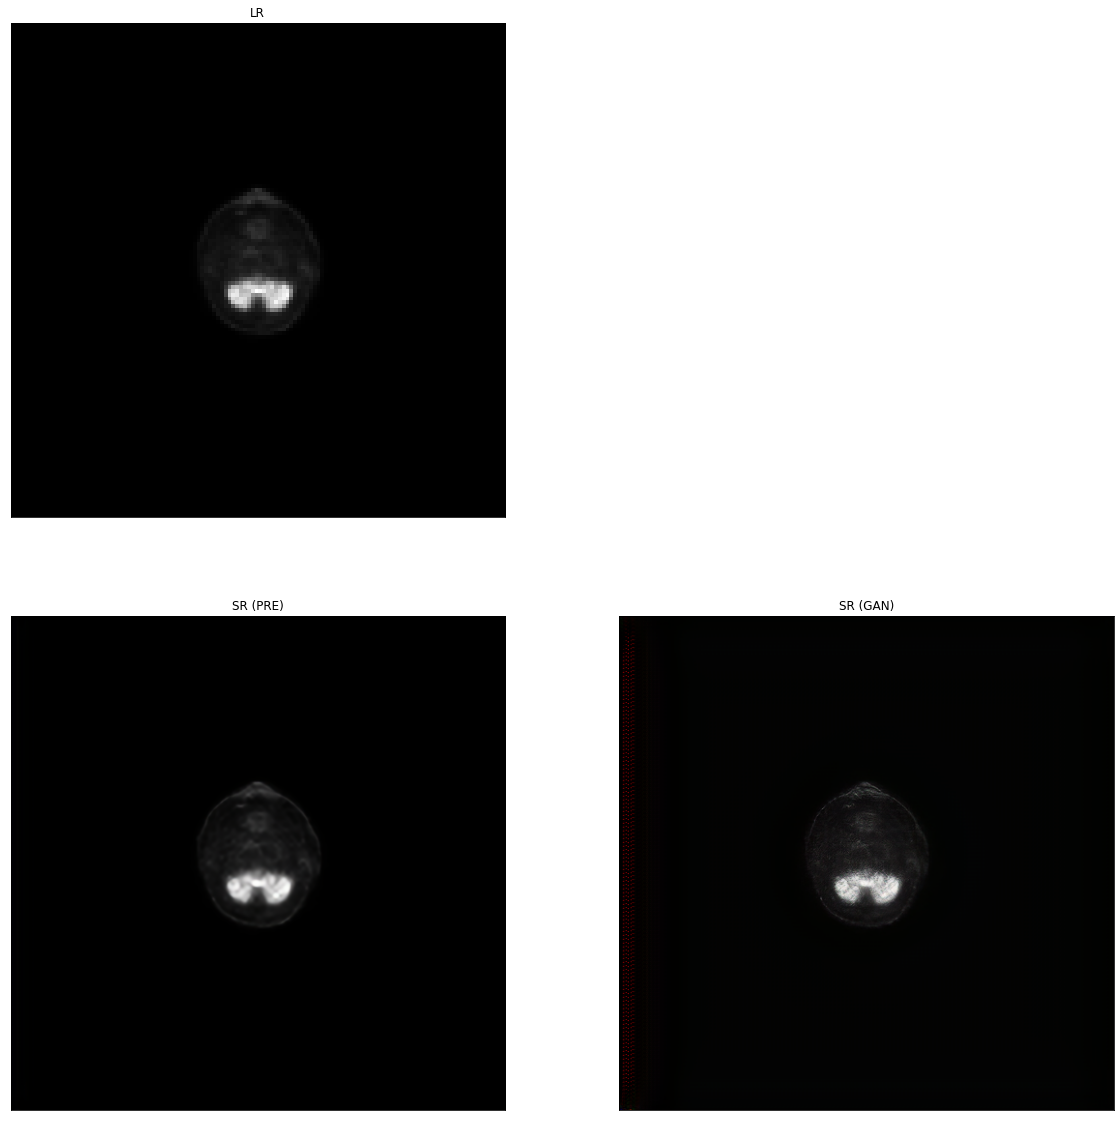

In [44]:
new_image = '/content/drive/MyDrive/super-resolution-master/new_dataset/PET-radiomics-challenges-kaggle/Test/1.3.6.1.4.1.14519.5.2.1.1707.8040.25195525414862185542009647.png'
convert_and_plot(new_image)

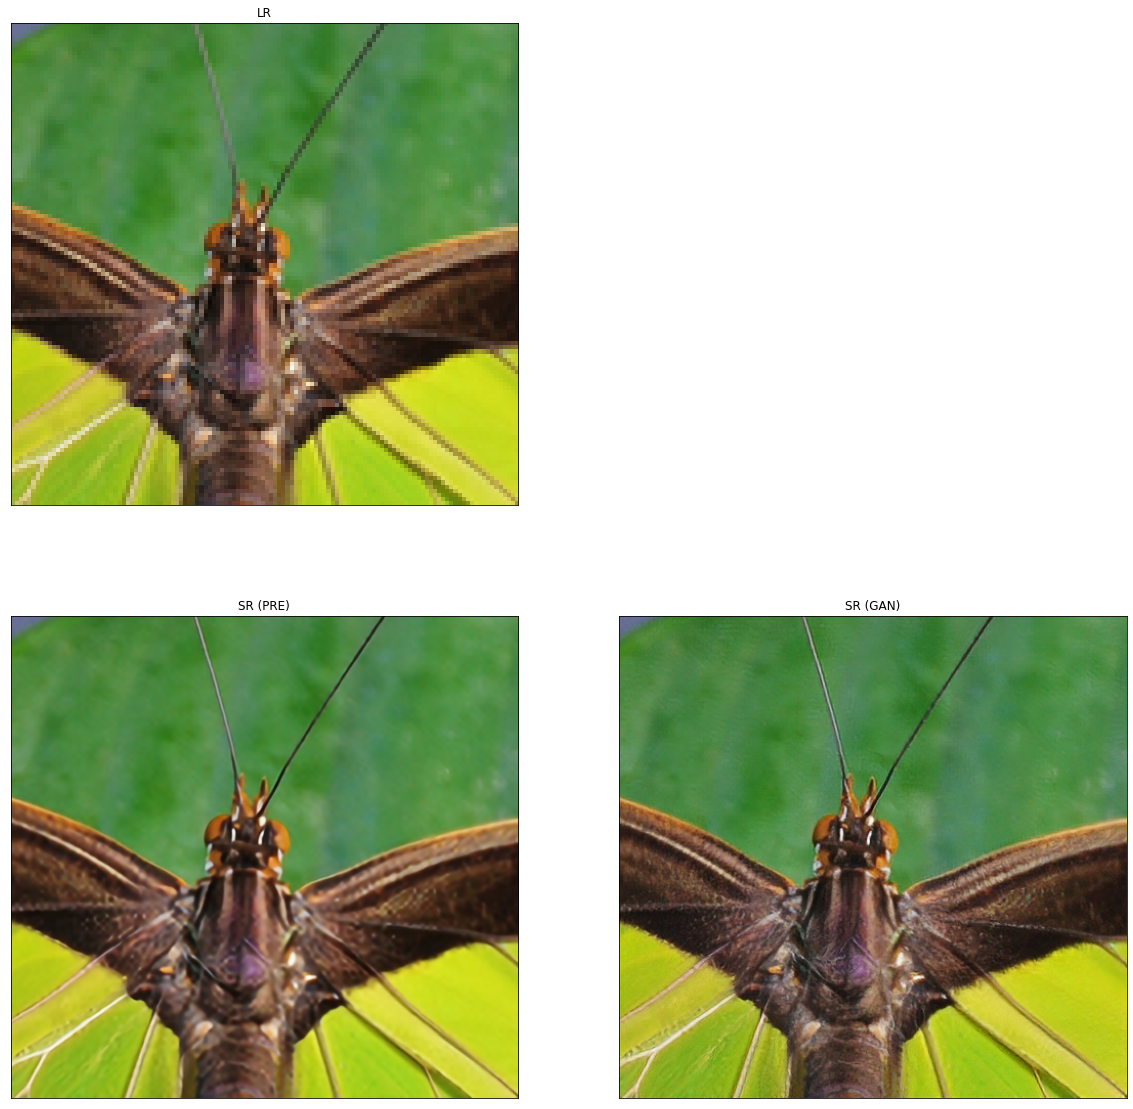

In [34]:
resolve_and_plot('demo/0829x4-crop.png')